In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%matplotlib inline

# Data Preprocessing

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_train_1_to_6.log']

body_part = "shoulder_right"
file_names = [
             './training_data/shoulder_right_train_10_17.log',
             './training_data_old/shoulder_right_data_6.log',
             './training_data_old/shoulder_right_data_7.log',
             './training_data_old/shoulder_right_data_8.log',
             './training_data_old/shoulder_right_data_9.log',
            ]

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_train_2.log',
#               './training_data/shoulder_left_train_5_6_7_9_10.log'
#              ]

In [3]:
orig_dataset = pd.concat([pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names])
orig_dataset = orig_dataset.values[1:len(orig_dataset)-1,0:]
# dataset = [data[(np.abs(stats.zscore(data[["roll", "pitch", "yaw"]])) < 2.75).all(axis=1)] for data in dataset]

abnormal_threshold = 0.5
dataset = []

for name in file_names:
    df = pd.read_csv(name, delim_whitespace=True, header=0)
    
    # interpolate nan outputs (loss tracking)
    for c in df.columns[-3:]:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
    for c in df.columns[:-3]:
        bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
        df.loc[bad_idx, c] = np.nan
        df[c] = df[c].interpolate()
    
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 

print(f'{np.sum(dataset_len)} values')

dataset = dataset.values[1:len(dataset)-1,0:]
dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]

print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

521420 values
521418 values after filtering outliers
max euler 2.013683795928955
min euler -3.141414165496826


## Orientation preprocessing 

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [5]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

## Normalization

In [6]:
sensors_scaler = MinMaxScaler(feature_range=(-1., 1.))

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.fit_transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)

## Torch dataloader

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [8]:
look_back = 10

data_in = []
data_hat_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(orig_sensors_set[i:i+look_back])
        data_hat_in.append(sensors_set[i:i+look_back])
        data_out.append(rot_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

348907
357314
424817
463358
521320


# Training

In [9]:
p = dict(
    seq_len = look_back,
    batch_size = 1000, 
    max_epochs = 100,
    n_frames = 4,
    n_observations = 3,
    n_actions = 0,
    n_latents = 16,
    n_outputs = 6,
    n_initial_obs = 3,
    hidden_size = 100,
    learning_rate = 5e-4,
    alpha = 0.1,
    beta = 1.5,
    annealing = 0.3,
    temperature = 1e4
)

In [10]:
model_path = f"./outputs/{body_part}_dvbf_rot6D"

if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(sensors_scaler, f'{model_path}/scaler.pkl')
with open(f'{model_path}/hyperparams.json', 'w') as fp:
    json.dump(p, fp)

In [11]:
seed_everything(1)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=model_path,
    filename="best-{epoch:03d}-{val_loss:.5f}",
    save_top_k=3,
    mode="min",
)

trainer = Trainer(
    max_epochs=p['max_epochs'],
    callbacks=[checkpoint_callback],
    gpus=1,
    log_every_n_steps=10,
    progress_bar_refresh_rate=2,
)

model = DVBF(
    n_frames = p['n_frames'],
    n_observations = p['n_observations'],
    n_actions = p['n_actions'],
    n_latents = p['n_latents'],
    n_outputs = p['n_outputs'],
    n_initial_obs = p['n_initial_obs'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    learning_rate = p['learning_rate'],
    alpha = p['alpha'],
    beta = p['beta'],
    annealing = p['annealing'],
    temperature = p['temperature'],
)


dm = SensorsDataModule(
#     data_x = data_in,
    data_x = data_hat_in,
    data_y = data_out,
#     data_x_hat = data_hat_in,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

Global seed set to 1
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=2)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dr

Validation sanity check: 0it [00:00, ?it/s]

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Global seed set to 1
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 w

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl': 4.0538177490234375,
 'test_loss': -19.42087745666504,
 'test_nllx': -24.384679794311523,
 'test_nlly': -11.169145584106445}
--------------------------------------------------------------------------------


[{'test_loss': -19.42087745666504,
  'test_nllx': -24.384679794311523,
  'test_nlly': -11.169145584106445,
  'test_kl': 4.0538177490234375}]

In [12]:
best_model_path = f"{model_path}/best.ckpt"
if os.path.exists(best_model_path):
    os.remove(best_model_path)
trainer.save_checkpoint(best_model_path)

# Testing 

In [13]:
device = "cuda"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=None)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models

In [14]:
def plot_test(sensors_set, euler_set, look_back=5, ab_idx=None):

    # Specific testing for abnormalities
    
    if body_part == "shoulder_right":
        start_idx = 110090
        end_idx = 110790
        ab_idx = 110690
    elif body_part == "shoulder_left":
        start_idx = 21500
        end_idx = 22880
        ab_idx = 22626
    elif body_part == "head":
        start_idx = 900
        end_idx = 950

    test_idxs = slice(start_idx, end_idx)

    # Prepare inputs and do the prediction
    in_set = []
    for i in range(start_idx, end_idx):
        in_set.append(sensors_set[i:i+look_back])

#     in_set = torch.tensor(in_set, dtype=torch.float32).to(device)
    in_set = torch.tensor(sensors_set[start_idx:end_idx][None], dtype=torch.float32).to(device)
    out_set = model.predict(in_set)[0]#[:, -1]
    rot_pred = compute_rotation_matrix_from_ortho6d(out_set)
    
    euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred)
    euler_gt = torch.tensor(euler_set[test_idxs], dtype=torch.float32).to(device)
    
    print(f"MSE: {mse_seq(euler_pred, euler_gt)}")
    
    euler_pred = euler_pred.cpu().detach().numpy()
    euler_gt = euler_gt.cpu().detach().numpy()

    # Plotting
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(euler_gt[:, 0], euler_gt[:, 1], euler_gt[:, 2], c=np.arange(len(euler_gt)), alpha=0.1)
    sc = ax.plot(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2])
    sc = ax.scatter(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2], c=np.arange(len(euler_pred)), alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.colorbar(sc)
    plt.show()
    
    # Abnormal analysis
    latent_dist = None
    if ab_idx is not None:
        ab_idx = ab_idx - start_idx
        latent_dist = model.inv_meas(in_set[:, ab_idx])
        print(f"Abnormal input: {in_set[:, ab_idx]}")
    return latent_dist

In [15]:
test_euler_set = dataset[:, 12:15]

MSE: 0.0006341974949464202


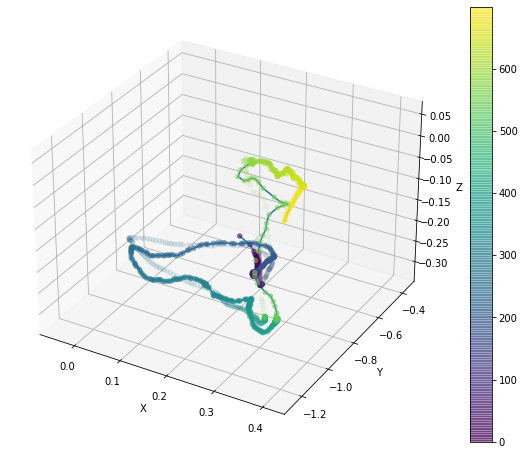

Abnormal input: tensor([[[ 0.0665,  0.6416,  0.5979],
         [ 0.1106, -0.5942,  0.7795],
         [-0.1069,  0.3333, -0.2064],
         [-0.1109,  0.1616, -0.0624]]], device='cuda:0')


In [16]:
# Plot with raw inputs
test_latent_dist = plot_test(sensors_set, test_euler_set, look_back=5)

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


MSE: 0.0007008670945651829


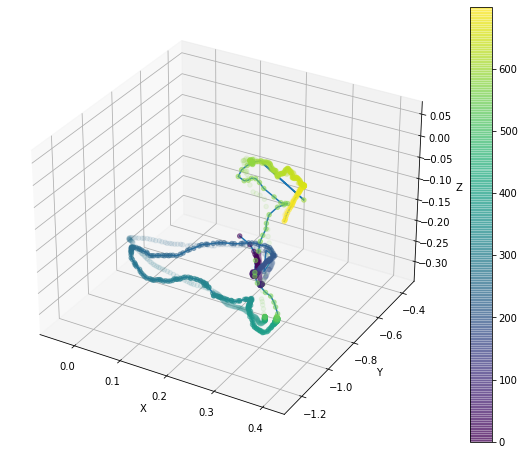

Abnormal input: tensor([[[-0.2319, -0.0155,  0.0441],
         [ 0.1106, -0.5942,  0.7795],
         [-0.1069,  0.3333, -0.2064],
         [-0.1109,  0.1616, -0.0624]]], device='cuda:0')


In [17]:
# Plot with interpolated inputs
orig_latent_dist = plot_test(orig_sensors_set, test_euler_set, look_back=5)

In [18]:
test_latent_mean = torch.stack(test_latent_dist[0])
test_latent_var = torch.stack(test_latent_dist[1])

In [19]:
orig_latent_mean = torch.stack(orig_latent_dist[0])
orig_latent_var = torch.stack(orig_latent_dist[1])

In [20]:
np.set_printoptions(precision=3, suppress=True)

In [21]:
test_latent_mean

tensor([[[ 13.3144,  34.1276,  18.4852, -29.5642,  33.8643,   6.2906,  -8.5682,
           25.3254,  17.5630, -17.2653,  -6.9595,  27.6519, -18.7231, -14.8541,
          -20.4540, -22.6791]],

        [[ 26.4230,  28.5782,  19.8168, -19.1515,  -4.4046, -30.8207,  19.1289,
            0.3002, -19.4701,  22.4883, -10.8826, -25.2579,  25.4457, -19.2987,
           -7.1951, -20.4433]],

        [[-10.5413,  23.7672, -11.7869, -17.2616, -14.5275,  18.3051, -26.6699,
          -27.8140,   5.2824,  17.8348,  17.6474,  10.8259, -11.5190,  -0.7061,
           12.0947,  16.7718]],

        [[-11.8071, -21.4082,  17.9581,  20.2418,   8.2919, -30.4340,  17.2779,
          -26.3439,   3.6795, -20.3733,  18.5319,  11.7416, -13.9494,  16.2188,
          -11.1531, -10.6602]]], device='cuda:0')

In [22]:
orig_latent_mean

tensor([[[  3.7802,  26.8231,  14.0437, -17.9544,  20.6239,   9.2453,  -5.1525,
            9.6852,  15.5180, -19.9038,  -3.6071,  21.9384, -13.3025,   0.5014,
          -18.6851, -11.0063]],

        [[ 26.4230,  28.5782,  19.8168, -19.1515,  -4.4046, -30.8207,  19.1289,
            0.3002, -19.4701,  22.4883, -10.8826, -25.2579,  25.4457, -19.2987,
           -7.1951, -20.4433]],

        [[-10.5413,  23.7672, -11.7869, -17.2616, -14.5275,  18.3051, -26.6699,
          -27.8140,   5.2824,  17.8348,  17.6474,  10.8259, -11.5190,  -0.7061,
           12.0947,  16.7718]],

        [[-11.8071, -21.4082,  17.9581,  20.2418,   8.2919, -30.4340,  17.2779,
          -26.3439,   3.6795, -20.3733,  18.5319,  11.7416, -13.9494,  16.2188,
          -11.1531, -10.6602]]], device='cuda:0')

In [23]:
(test_latent_mean - orig_latent_mean).abs().cpu().numpy()

array([[[ 9.534,  7.305,  4.442, 11.61 , 13.24 ,  2.955,  3.416, 15.64 ,
          2.045,  2.639,  3.352,  5.714,  5.421, 15.356,  1.769, 11.673]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
          0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]],
      dtype=float32)

In [24]:
(test_latent_var - orig_latent_var).abs().cpu().numpy()

array([[[  0.356,   0.795,  11.999,   0.024,   7.908,   0.496,  16.609,
           1.412,  21.834,   0.807,   0.153,   0.094,   3.312, 306.998,
           0.38 ,   1.113]],

       [[  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ]],

       [[  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ]],

       [[  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
           0.   ,   0.   ]]], dtype=float32)

In [25]:
test_latent_var

tensor([[[7.5234e-01, 3.4260e+00, 1.6040e+01, 3.3177e+00, 1.2845e+01,
          5.1072e-01, 2.0143e+01, 2.9457e+00, 2.2482e+01, 6.4228e-01,
          6.0116e-02, 1.2257e+01, 1.4659e+01, 3.1598e+02, 1.9931e+00,
          6.6338e-01]],

        [[1.6276e+00, 1.1697e+01, 7.2549e+00, 5.0579e+00, 8.2124e+01,
          2.0954e+00, 3.2650e+00, 1.8460e+00, 2.1242e-01, 8.2481e-01,
          5.5610e-01, 1.9956e+00, 3.4243e+00, 1.1983e+00, 1.2366e+00,
          2.4388e+00]],

        [[1.2071e+00, 3.7182e+00, 1.1755e+00, 6.0099e+01, 1.5922e+00,
          2.1593e+00, 3.5356e+00, 2.2255e+01, 6.9852e-01, 3.6030e+00,
          8.8311e-01, 3.7718e+00, 5.8335e+00, 1.9276e+00, 2.2888e-01,
          6.8698e-01]],

        [[5.7094e-01, 1.7695e+00, 2.5251e+00, 1.4937e+00, 1.7387e+00,
          4.1649e+00, 4.5024e+00, 4.0388e+00, 6.7093e-01, 4.2034e+00,
          7.0787e-01, 2.4952e+00, 6.5692e+00, 1.1765e+00, 1.0612e+00,
          3.1963e+01]]], device='cuda:0')

In [26]:
orig_latent_var

tensor([[[ 0.3959,  2.6307,  4.0406,  3.2942,  4.9369,  1.0066,  3.5348,
           1.5339,  0.6476,  1.4489,  0.2135, 12.3513, 11.3469,  8.9843,
           2.3730,  1.7761]],

        [[ 1.6276, 11.6972,  7.2549,  5.0579, 82.1245,  2.0954,  3.2650,
           1.8460,  0.2124,  0.8248,  0.5561,  1.9956,  3.4243,  1.1983,
           1.2366,  2.4388]],

        [[ 1.2071,  3.7182,  1.1755, 60.0988,  1.5922,  2.1593,  3.5356,
          22.2551,  0.6985,  3.6030,  0.8831,  3.7718,  5.8335,  1.9276,
           0.2289,  0.6870]],

        [[ 0.5709,  1.7695,  2.5251,  1.4937,  1.7387,  4.1649,  4.5024,
           4.0388,  0.6709,  4.2034,  0.7079,  2.4952,  6.5692,  1.1765,
           1.0612, 31.9628]]], device='cuda:0')

In [27]:
abnormal_idx = np.where(np.abs(sensors_set - orig_sensors_set) > 0.5)

In [28]:
abnormal_idx

(array([  6359,   7282,   7861,  10877,  18195,  20239,  20239,  22348,
         22348,  23255,  28222,  28222,  28222,  31384,  31384,  32200,
         32200,  36783,  40562,  43777,  43777,  46872,  47596,  49206,
         49206,  54548,  54548,  54548,  57452,  61673,  61673,  64080,
         65461,  65461,  71214,  71214,  71733,  71733,  75343,  75343,
         75343,  76828,  80736,  83577,  83577,  88961,  88961,  99868,
        105754, 105754, 110690, 110690, 110970, 115034, 115962, 115962,
        120417, 123952, 126027, 128826, 128826, 129269, 130274, 130274,
        130299, 130299, 142657, 146754, 148496, 148496, 149746, 150588,
        161092, 171772, 185709, 186262, 192433, 198430, 199022, 199022,
        199606, 199606, 199606, 207450, 207450, 208368, 208368, 208368,
        209362, 209362, 213657, 213657, 213657, 217936, 220533, 222209,
        222968, 223023, 224902, 234968, 234968, 237943, 244524, 244524,
        254902, 254902, 255413, 258481, 258481, 258481, 266078, 